# CMIP6 sea ice data
In this notebook, we will download data from a subset of CMIP6 models that have sea ice concentration (`siconc`), sea surface temperature (`tos`) and primary production (derived from `epc100`, `intpp`, `phyc` and `zooc`) available as outputs. Model outputs for the Southern Ocean (from the Antarctic coastline to $30^{\circ}$S) will be extracted and standardised using the `xmip` package.  

The data will be subsetted across time to the period between January 1982 and December 2010 and finally it will be regridded to match the GFDL-MOM6-COBALT2 data used to force FishMIP models. The regridded CMIP6 data can then be used to compare against GFDL-MOM6-COBALT2 and observations.  

## Loading relevant libraries

In [1]:
#Downloading data
import requests

#Loading and manipulating netcdf files
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd

#Standardisation of CMIP6 data for easy data post-processing
from xmip.preprocessing import rename_cmip6, promote_empty_dims, broadcast_lonlat, correct_coordinates

#Dealing with file paths
import os
from glob import glob
import re

#Regridding
import xesmf as xe

## Setting working directory

In [2]:
os.chdir('/g/data/jk72/la6889/FishMIP/SOMEME/')

## Loading information about CMIP6 datasets to be downloaded

In [84]:
CMIP6_query = pd.read_csv('data/someme_results.csv')
CMIP6_query.head()

,file_id,dataset_id,mip_era,activity_drs,institution_id,source_id,experiment_id,member_id,table_id,frequency,...,variable_id,variable_long_name,variable_units,datetime_start,datetime_end,file_size,data_node,file_url,dataset_pid,tracking_id
0,CMIP6.CMIP.MOHC.UKESM1-0-LL.historical.r9i1p1f...,CMIP6.CMIP.MOHC.UKESM1-0-LL.historical.r9i1p1f...,CMIP6,CMIP,MOHC,UKESM1-0-LL,historical,r9i1p1f2,SImon,mon,...,siconc,Sea-ice Area Percentage (Ocean Grid),%,1950-01-01T00:00:00Z,2014-12-01T00:00:00Z,57893194,esgf.ceda.ac.uk,https://esgf.ceda.ac.uk/thredds/fileServer/esg...,hdl:21.14100/3dec87f6-3e67-3896-9b88-d36019dc7302,hdl:21.14100/7380f8b5-32a0-4e24-a2b6-42cce691ad2a
1,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6,CMIP,NCC,NorESM2-LM,historical,r2i1p1f1,SImon,mon,...,siconc,Sea-Ice Area Percentage (Ocean Grid),%,1970-01-01T00:00:00Z,1979-12-01T00:00:00Z,11864106,noresg.nird.sigma2.no,http://noresg.nird.sigma2.no/thredds/fileServe...,hdl:21.14100/66e15d86-03de-3b9d-adc5-d6ebbff5a46d,hdl:21.14100/d6613877-29c6-4c82-b5ef-24864be82223
2,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6,CMIP,NCC,NorESM2-LM,historical,r2i1p1f1,SImon,mon,...,siconc,Sea-Ice Area Percentage (Ocean Grid),%,1980-01-01T00:00:00Z,1989-12-01T00:00:00Z,11903362,noresg.nird.sigma2.no,http://noresg.nird.sigma2.no/thredds/fileServe...,hdl:21.14100/66e15d86-03de-3b9d-adc5-d6ebbff5a46d,hdl:21.14100/f3cc081b-386e-4ad4-857c-30c1b0e60574
3,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6,CMIP,NCC,NorESM2-LM,historical,r2i1p1f1,SImon,mon,...,siconc,Sea-Ice Area Percentage (Ocean Grid),%,1990-01-01T00:00:00Z,1999-12-01T00:00:00Z,11897215,noresg.nird.sigma2.no,http://noresg.nird.sigma2.no/thredds/fileServe...,hdl:21.14100/66e15d86-03de-3b9d-adc5-d6ebbff5a46d,hdl:21.14100/e7e789e7-f6ef-4093-9b20-ef9b8998fbbb
4,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6.CMIP.NCC.NorESM2-LM.historical.r2i1p1f1....,CMIP6,CMIP,NCC,NorESM2-LM,historical,r2i1p1f1,SImon,mon,...,siconc,Sea-Ice Area Percentage (Ocean Grid),%,2000-01-01T00:00:00Z,2009-12-01T00:00:00Z,11837306,noresg.nird.sigma2.no,http://noresg.nird.sigma2.no/thredds/fileServe...,hdl:21.14100/66e15d86-03de-3b9d-adc5-d6ebbff5a46d,hdl:21.14100/024c2341-c86f-433d-9e28-2a72cabc1623


## Defining functions to standardise CMIP6 outputs

In [7]:
def standard(dataset):
  #Renaming all variables so they are the same for all models
  dataset = rename_cmip6(dataset)
  #Adding an index if not included
  dataset = promote_empty_dims(dataset)
  #Converting coordinates from 1D to 2D arrays
  dataset = broadcast_lonlat(dataset)
  #Correcting coordinates if needed so they appear in format 0-360 degrees
  dataset = correct_coordinates(dataset)
  return dataset

## Defining function to download CMIP6 outputs
This function uses the information provided in the data frame above and downloads data from ESGF servers. CMIP6 outputs are standardised before being subset to cover the Southern Ocean only and finally downloaded.

In [8]:
def download_cmip(url, var, fout):
    #Establishes a connection 
    link = requests.get(url).content
    remote = Dataset(var, memory = link)
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(remote))
    ds = standard(ds)[var]
    ds = ds.where(ds.lat <= -30, drop = True)
    ds.to_netcdf(fout)

## Downloading standardised CMIP6 sea ice data

In [39]:
for i in CMIP6_query.index:
    row =  CMIP6_query.iloc[i]
    [base_file] = re.findall('.*nc', row.file_id.split('|')[0])
    fout = os.path.join('data/CMIP6', base_file)
    url = row.file_url
    var = row.variable_id
    download_cmip(url, var, fout)

## Saving data for the period of interesting in a single file
To facilitate comparisons, we will save data for the comparison period (January 1982-December 2010) in a single file prior to regridding. Note that the sea ice outputs (`siconc`) coordinates (i.e., latitude and longitude) from CESM2 model need to be corrected. We will use the `areacello` file, which contain the correct coordinate information.

In [3]:
si_files = glob('data/CMIP6/*SImon*')

for m in CMIP6_query.source_id.unique():
    mod_files = sorted([f for f in si_files if f'{m}.h' in f])
    da = xr.open_mfdataset(mod_files)['siconc'].sel(time = slice('1982', '2010'))
    out_name = os.path.basename(mod_files[0])
    #Longitude and latitude values need to be corrected in CESM2 data
    if 'CESM2.' in out_name:
        #Identify CESM areacello file
        [ocean] = glob('data/CMIP6/*areacello*CESM2*')
        #Load data array
        da_ocean = xr.open_dataarray(ocean)
        #Start an empty dataset to store corrected coordinates
        da_sic_fix = xr.Dataset()
        #Add SIC data 
        da_sic_fix['siconc'] = (('time', 'y', 'x'), da.data)
        #Add latitude and longitude from areacello file
        da_sic_fix.coords['lat'] = (('y', 'x'), da_ocean['lat'].values)
        da_sic_fix.coords['lon'] = (('y', 'x'), da_ocean['lon'].values)
        #Add time from the SIC file
        da_sic_fix.coords['time'] = (da['time'].values)
        #Overwrite SIC file
        da = da_sic_fix['siconc']
    #Save dataset for period of interest
    out_path = os.path.join('data/CMIP6/clean_CMIP6/', re.sub('[0-9]{6}-[0-9]{6}', '198201-201012', out_name))
    da.to_netcdf(out_path)

## Regridding CMIP6 data
Before comparisons, we will regrid sea ice data from all CMIP6 models to a common grid. We chose to use GFDL-MOM6-COBALT2 as the target grid because it is in a regular $1^{\circ}$ horizontal grid.

### Loading sample grid from GFDL-MOM6-COBALT2

0.3.0


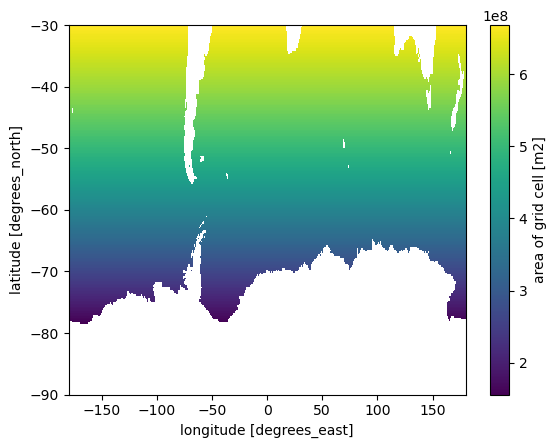

In [3]:
#Load GFDL data
gfdl_grid = xr.open_dataarray('data/gfdl-mom6-cobalt2_areacello_15arcmin_global_fixed.nc')
#Select area of interest
gfdl_grid = gfdl_grid.sel(lat = slice(-30, -90))
#Check result
gfdl_grid.plot()

### Regridding CMIP6 data
We will use a bilinear algorithm to perform regridding of the clean CMIP6 sea ice outputs.

In [4]:
#Getting list of clean CMIP6 files 
comp_files = glob('data/CMIP6/clean_CMIP6/*.nc')

#Regridding data
for f in comp_files:
    #Get name of file being loaded
    fout = re.sub('gn', '15arcmin', os.path.basename(f))
    #Load data
    ds = xr.open_dataarray(f)
    #Calculate regridder
    reg = xe.Regridder(ds, gfdl_grid, 'bilinear')
    #Apply regridder
    ds_reg = reg(ds)
    #Save regridded data
    ds_reg.to_netcdf(os.path.join('data/CMIP6/regridded_CMIP6/', fout))

## Calculating climatological means
We will calculate two types of climatologies: seasonal and monthly for each CMIP6 model. We will save these climatologies to allow comparisons later.

In [5]:
#Get list of regridded CMIP6 data
comp_files = glob('data/CMIP6/regridded_CMIP6/*.nc')

#Loop through each file
for f in comp_files:
    #Load regridded data
    da = xr.open_dataarray(f)
    #Check if maximum SIC values are below 1, if so, multiply by 100
    if da.max() <= 1:
        da = da*100
    #Calculate seasonal and monthly climatologies
    da_clim = xr.where(da < 10, np.nan, da).groupby('time.season').mean()
    da_month_clim = xr.where(da < 10, np.nan, da).groupby('time.month').mean()
    #Create a new file name based on original file name
    fout_clim = re.sub('[0-9]{6}-[0-9]{6}', 'seasonal_climatology_1982-2010', os.path.basename(f))
    fout_month_clim = re.sub('[0-9]{6}-[0-9]{6}', 'monthly_climatology_1982-2010', os.path.basename(f))
    #Save climatologies
    da_clim.to_netcdf(os.path.join('data/CMIP6/climatologies/', fout_clim))
    da_month_clim.to_netcdf(os.path.join('data/CMIP6/climatologies/', fout_month_clim))